필요한 모듈 로딩

In [269]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import load_model

파일을 읽어와 딕셔너리에 저장 ( 기간 설정 )

In [266]:
def initial_dict(sector_size,start_month,end_month):
    dic = {}
    for number in range(1,sector_size+1):
        dic[str(number)] = {}
        for month in range(start_month,end_month+1):
            dic[str(number)][str(month)] = {}
    return dic
if __name__ == "__main__":
    Attribute_name_list = ['hour','minute','pm2_5_value','pm10_value','co_value','hum_value','temp_value',\
                           'station_num','factory_num','construction_num','no2_value','voc_value','so2_value']
    #학습할 기간(데이터내 기간) 설정
    Start_month = 7
    End_month = 11
    Sector_size = 28
    File_name = ''
    All_dataset = initial_dict(Sector_size,Start_month,End_month)
    for month in range(Start_month,End_month+1):
        #파일을 읽어오고 속성값들 읽어옴
        Attributes = []
        File_name = './10분/'+str(month)+'월.txt'
        f = open(File_name,'r')
        Attributes_line = f.readline()
        for attribute in Attributes_line.strip().split('|'):
            Attributes.append(attribute)
        
        #속성값들의 인덱스를 구하는 과정    
        Sector_index = Attributes.index('sector')
        Month_index = Attributes.index('month')
        Day_index = Attributes.index('day')
        Hour_index = Attributes.index('hour')
        Min_index = Attributes.index('minute')
        Attribute_indexes = []
        for attribute_name in Attribute_name_list:
            Attribute_indexes.append(Attributes.index(attribute_name))
            
        #데이터셋에 튜플내용들 추가
        key_hour_list = []
        value_list = []
        min_value,max_value = 1,160 # 사전에 결정.
        for tuple_line in f.readlines():
            attribute = tuple_line.strip().split('|')
            key_hour_list.append([attribute[Sector_index],attribute[Month_index],attribute[Day_index],attribute[Hour_index],attribute[Min_index]])
            temp = []
            for index in Attribute_indexes:
                temp.append(float(attribute[index]))

            value_list.append(temp)
        index = 0
        for key in key_hour_list:
            try:
                temp = (value_list[index])
                All_dataset[key[Sector_index]][key[Month_index]][key[Day_index]].append(temp)
                index += 1
            except:
                All_dataset[key[Sector_index]][key[Month_index]][key[Day_index]]=[temp]
                index += 1
        f.close()

트레이닝,테스트 데이터셋 생성

In [258]:
def make_train_dataset(All_dataset,sector_size,start_month,start_day,end_month,end_day,attribute_name_list,look_back,time):
    target = 'pm10_value' # 목표 속성값 선택
    #학습에 사용할 속성 값 선택
    train_attribute_name_list = ['pm2_5_value','pm10_value','co_value','hum_value','temp_value',\
                          'station_num','factory_num','construction_num','no2_value','voc_value','so2_value']
    train_index = []
    for name in train_attribute_name_list:
        train_index.append(attribute_name_list.index(name))
    trainX,trainY = [],[]
    target_index = train_attribute_name_list.index(target)
    for sector in range(1,sector_size+1):
        dataset = []
        for month in range(start_month,end_month+1):
            if start_month == end_month:
                start = start_day
                end = end_day
            else:
                if month == start_month:
                    start = start_day
                    end = len(All_dataset[str(sector)][str(month)])
                elif month == end_month:
                    start = 1
                    end = end_day
                else:
                    start = 1
                    end = len(All_dataset[str(sector)][str(month)])
            try:
                for day in range(start,end+1):
                    for i in range(len(All_dataset[str(sector)][str(month)][str(day)])):
                        temp = []
                        for j in train_index:
                            temp.append(All_dataset[str(sector)][str(month)][str(day)][i][j])
                        dataset.append(temp)
            except KeyError:
                pass
        for i in range(len(dataset)-look_back):
            if len(dataset) < (i+time+look_back):
                break
            temp_list = dataset[i:(i+look_back)]
            trainX.append(temp_list)
            trainY.append(dataset[i+time+look_back-1][target_index])            
    batch_size = int(len(trainX)/sector_size)
    return np.array(trainX),np.array(trainY),batch_size

def make_test_dataset(All_dataset,sector_size,month,day,attribute_name_list,look_back,time):
    target = 'pm10_value'
    test_attribute_name_list = ['pm2_5_value','pm10_value','co_value','hum_value','temp_value',\
                          'station_num','factory_num','construction_num','no2_value','voc_value','so2_value']
    testX,testY = [],[]
    test_index = []
    for name in test_attribute_name_list:
        test_index.append(attribute_name_list.index(name))
    target_index = test_attribute_name_list.index(target)
    for sector in range(1,sector_size+1):
        dataset = []
        for i in range(len(All_dataset[str(sector)][str(month)][str(day)])):
            temp = []
            for j in test_index:
                temp.append(All_dataset[str(sector)][str(month)][str(day)][i][j])
            dataset.append(temp)
        for i in range(len(dataset)-look_back):
            if len(dataset) < (i+time+look_back):
                break
            temp_list = dataset[i:(i+look_back)]
            testX.append(temp_list)
            testY.append(dataset[i+time+look_back-1][target_index])
            
    batch_size = int(len(testX)/sector_size)
    return np.array(testX),np.array(testY),batch_size

def make_test_data_time(All_dataset,sector_size,month,day,start_time,attribute_name_list,look_back,time):
    target = 'pm10_value'
    test_attribute_name_list = ['pm2_5_value','pm10_value','co_value','hum_value','temp_value',\
                          'station_num','factory_num','construction_num','no2_value','voc_value','so2_value']
    testX,testY = [],[]
    test_index = []
    for name in test_attribute_name_list:
        test_index.append(attribute_name_list.index(name))
    target_index = test_attribute_name_list.index(target)
            
    for sector in range(1,sector_size+1):
        dataset = []
       # print(dataset)
        for i in range(len(All_dataset[str(sector)][str(month)][str(day)])):
            temp = []
            for j in test_index:
                temp.append(All_dataset[str(sector)][str(month)][str(day)][i][j])
            dataset.append(temp)
        try:
            temp_list = dataset[(start_time-look_back+1):start_time+1]
            testX.append(temp_list)
            testY.append(dataset[start_time+time-1][target_index])
        except:
            print('Data period or Look_back or Predict Time error')
            
    return np.array(testX),np.array(testY)

스케일러 된 값 수정 및 구획별 예측값 평균을 구함

In [5]:
def inverse_Scaler(data,max_value,min_value):
    inverse_data = []
    for i in range(len(data)):
        try:
            inverse_data.append(data[i][0]*(max_value-min_value)+min_value)
        except IndexError:
            inverse_data.append(data[i]*(max_value-min_value)+min_value)
    return inverse_data

def average_value(data,Sector_size,batch_size):
    average_list = []
    for i in range(0,batch_size):
        temp = data[i]
        for j in range(1,Sector_size-1):
            temp += data[i+batch_size*j]
        average = temp/Sector_size
        average_list.append(average)
    return average_list

현재시점에서 얼만큼의 전의 데이터를 볼것인지와 몇 시간 후를 예측할지를 정함

In [273]:
look_back = 3
time = 3
trainX,trainY,train_batch_size = make_train_dataset(All_dataset,Sector_size,7,1,11,13,Attribute_name_list,look_back,time)

In [274]:
testX,testY,test_batch_size = make_test_dataset(All_dataset,Sector_size,11,14,Attribute_name_list,look_back,time)

모델 학습

In [275]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(look_back, 11)))
model.add(LSTM(16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(trainX,trainY, epochs=10,batch_size=train_batch_size)

Epoch 1/10
548212/548212 [==============================] - 19s 35us/step - loss: 0.0265
Epoch 2/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0103
Epoch 3/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0071
Epoch 4/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0069
Epoch 5/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0067
Epoch 6/10
548212/548212 [==============================] - 14s 26us/step - loss: 0.0067
Epoch 7/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0066
Epoch 8/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0065
Epoch 9/10
548212/548212 [==============================] - 14s 25us/step - loss: 0.0065
Epoch 10/10
548212/548212 [==============================] - 14s 26us/step - loss: 0.0064


In [268]:
# make predictions
trainPredict = model.predict(trainX,batch_size=train_batch_size)
testPredict = model.predict(testX,batch_size=test_batch_size)

In [61]:
# invert predictions
trainPredict = inverse_Scaler(trainPredict,max_value,min_value)
trainY = inverse_Scaler(trainY,max_value,min_value)

average_trainPredict = average_value(trainPredict,Sector_size,train_batch_size)
average_trainY = average_value(trainY,Sector_size,train_batch_size)

In [271]:
testPredict = inverse_Scaler(testPredict,max_value,min_value)
testY = inverse_Scaler(testY,max_value,min_value)

average_testPredict = average_value(testPredict,Sector_size,test_batch_size)
average_testY = average_value(testY,Sector_size,test_batch_size)

In [75]:
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: Found input variables with inconsistent numbers of samples: [12628, 453]

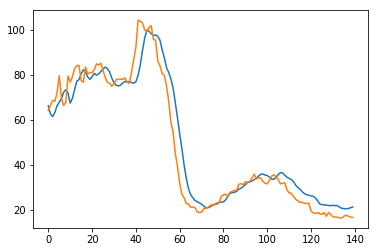

In [272]:
plt.plot(average_testPredict[:])
plt.plot(average_testY[:])
plt.show()

In [276]:
model.save('./10min-3time.h5')

In [ ]:
def save_result(data):
    